# SETUP

In [1]:
%%bash
pip install --upgrade pip tensorflow keras &> pip.log
pip install jupyterlab-vim pydot 'tensorflow[and-cuda]' >> pip.log
apt-get install graphviz -y &> apt.log

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Custom libraries written by myself
from src.drawing.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM

# Configuration reader
from src.config_reader.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

E0000 00:00:1751690024.292504 2519529 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751690024.299296 2519529 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751690024.315832 2519529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751690024.315862 2519529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751690024.315864 2519529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751690024.315865 2519529 computation_placer.cc:177] computation placer already registered. Please check linka

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")

print(conf)

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf.data["workspace"]["model_info_dir"])
cleanDir(conf.data["workspace"]["model_checkpoints_dir"])
cleanDir(conf.data["workspace"]["data_by_location_dir"])
cleanDir(conf.data["workspace"]["data_statistic_dir"])

{
    "dataset": {
        "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
        "target_start_date": "2021-01-01",
        "target_end_date": "2022-12-31"
    },
    "workspace": {
        "model_info_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_info",
        "model_checkpoints_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_checkpoints",
        "data_by_location_dir": "/le_thanh_van_118/workspace/hiep_workspace/data_by_location",
        "data_statistic_dir": "/le_thanh_van_118/workspace/hiep_workspace/data_statistic"
    },
    "prediction": {
        "n_past": 7,
        "n_future": 1,
        "epochs": 20,
        "batch_size": 128
    },
    "reduction": {
        "n_past": 7,
        "n_future": 1,
        "epochs": 20,
        "batch_size": 128,
        "min_number_of_features": 18
    }
}


# MPAIR DATA

## Load dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [4]:
df_mpair_raw = pd.read_csv(conf.data["dataset"]["file_dir"])
df_mpair_raw

,i,j,lat,lon,time,PM25_3km,TMP,RH,HPBL,WSPD,...,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD,AIMODEL
0,0,0,11.149747,106.300443,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000
1,0,1,11.149747,106.323330,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000
2,0,2,11.149747,106.346217,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,0.156327,-9999.000000
3,0,3,11.149747,106.369103,2018-01-01,24.740000,25.460614,65.144661,2.448070,2.448070,...,7.265194e+01,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.167487,-9999.000000
4,0,4,11.149747,106.391990,2018-01-01,23.760931,25.462688,65.080498,2.438784,2.438784,...,1.107789e+02,4569.189136,21119.949784,76052.614180,231046.865089,662859.174184,4308.164827,NaN,0.141881,-9999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236845,34,30,10.385233,106.987043,2022-12-31,NaN,25.815809,74.737156,207.873199,3.124345,...,3.072120e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000,14.998473
2236846,34,31,10.385233,107.009930,2022-12-31,NaN,25.815809,75.000397,207.873199,3.215876,...,4.355371e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000,15.201084
2236847,34,32,10.385233,107.032816,2022-12-31,-9999.000000,25.601173,-9999.000000,142.227615,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0.000000
2236848,34,33,10.385233,107.055703,2022-12-31,-9999.000000,25.560753,-9999.000000,129.865280,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0.000000


In [5]:
df_mpair_raw.columns

Index(['i', 'j', 'lat', 'lon', 'time', 'PM25_3km', 'TMP', 'RH', 'HPBL', 'WSPD',
       'PRES2M', 'POP', 'ROAD_DEN_1km', 'ROAD_LEN_1km', 'PRIM_ROAD_LEN_1km',
       'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND',
       'TREECOVER', 'WATER', 'NDVI', 'AOD', 'AIMODEL'],
      dtype='object')

### Statistics

In [6]:
df_mpair_stat = df_mpair_raw.describe()
df_mpair_stat.to_csv(f'{conf.data["workspace"]["data_statistic_dir"]}/df_mpair_stat.csv')

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [7]:
df_mpair_stat.iloc[:, list(range(0,12))]

,i,j,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,PRES2M,POP,ROAD_DEN_1km
count,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.222980e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06
mean,1.700000e+01,1.700000e+01,1.076749e+01,1.066895e+02,-1.753033e+03,-1.362026e+03,-1.661220e+03,-9.405143e+02,-1.725172e+03,8.546206e+04,-1.543609e+04,-5.388961e+37
std,1.009951e+01,1.009951e+01,2.270946e-01,2.311440e-01,3.818433e+03,3.463384e+03,3.810681e+03,3.635621e+03,3.781445e+03,3.828034e+04,3.946800e+04,1.242320e+38
min,0.000000e+00,0.000000e+00,1.038523e+01,1.063004e+02,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999900e+04,-3.402823e+38
25%,8.000000e+00,8.000000e+00,1.056512e+01,1.064835e+02,7.578345e+00,2.544704e+01,6.850341e+01,3.422755e+02,1.769627e+00,1.004902e+05,1.236246e+02,6.451674e-01
50%,1.700000e+01,1.700000e+01,1.076749e+01,1.066895e+02,1.195651e+01,2.657075e+01,7.868076e+01,4.752339e+02,2.600184e+00,1.007760e+05,5.454543e+02,4.697491e+00
75%,2.600000e+01,2.600000e+01,1.096986e+01,1.068955e+02,1.688797e+01,2.744273e+01,8.641529e+01,6.056798e+02,3.479031e+00,1.009805e+05,1.298022e+03,8.067769e+00
max,3.400000e+01,3.400000e+01,1.114975e+01,1.070786e+02,1.028131e+02,3.323537e+01,9.956794e+01,1.568239e+03,1.281917e+01,1.015956e+05,5.684037e+04,3.491340e+01


In [8]:
df_mpair_stat.iloc[:, list(range(12,24))]

,ROAD_LEN_1km,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD,AIMODEL
count,1.822348e+06,394416.000000,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,779702.000000,2.235890e+06,2.236850e+06
mean,1.067029e+04,131.058152,-inf,1.261559e+04,1.638713e+05,1.416377e+05,1.060141e+05,2.498923e+05,7.916829e+04,-2501.601072,-inf,-5.994904e+03
std,9.746935e+03,832.895664,inf,2.472116e+04,2.217233e+05,1.922052e+05,9.731447e+04,2.296573e+05,1.633040e+05,7461.592816,NaN,4.906239e+03
min,0.000000e+00,0.000000,-1.797693e+308,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9999.000000,-inf,-9.999000e+03
25%,4.510964e+03,0.000000,2.799286e+01,5.552163e+02,2.151326e+03,3.157222e+03,1.093264e+04,1.518208e+04,5.424711e+01,-9999.000000,-9.999000e+03,-9.999000e+03
50%,8.658898e+03,0.000000,7.090635e+01,4.823034e+03,7.965172e+04,4.737217e+04,1.005260e+05,2.117074e+05,6.301000e+03,1718.917701,-9.999000e+03,-9.999000e+03
75%,1.443556e+04,0.000000,1.625445e+02,1.730109e+04,2.221508e+05,2.185754e+05,1.665998e+05,3.996788e+05,8.267868e+04,4856.353630,4.555829e-01,1.600679e+01
max,5.460836e+04,8309.180000,6.176464e+03,2.330341e+05,9.817100e+05,8.584316e+05,5.151408e+05,9.725638e+05,1.249447e+06,7861.422519,5.469734e+00,4.573877e+01


In [9]:
df_mpair_raw.isnull().sum()

i                          0
j                          0
lat                        0
lon                        0
time                       0
PM25_3km               13870
TMP                        0
RH                         0
HPBL                       0
WSPD                       0
PRES2M                     0
POP                        0
ROAD_DEN_1km               0
ROAD_LEN_1km          414502
PRIM_ROAD_LEN_1km    1842434
NEAR_DIST                  0
BARELAND                   0
BUILTUP                    0
CROPLAND                   0
GRASSLAND                  0
TREECOVER                  0
WATER                      0
NDVI                 1457148
AOD                      960
AIMODEL                    0
dtype: int64

### Drop AIMODEL column

In [10]:
# The AIMODEL is not necessary for prediction, let's remove it
df_mpair_raw.drop(["AIMODEL"], axis=1, inplace=True)
df_mpair_raw

,i,j,lat,lon,time,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,0,0,11.149747,106.300443,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
1,0,1,11.149747,106.323330,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
2,0,2,11.149747,106.346217,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,0.156327
3,0,3,11.149747,106.369103,2018-01-01,24.740000,25.460614,65.144661,2.448070,2.448070,...,NaN,7.265194e+01,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.167487
4,0,4,11.149747,106.391990,2018-01-01,23.760931,25.462688,65.080498,2.438784,2.438784,...,NaN,1.107789e+02,4569.189136,21119.949784,76052.614180,231046.865089,662859.174184,4308.164827,NaN,0.141881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236845,34,30,10.385233,106.987043,2022-12-31,NaN,25.815809,74.737156,207.873199,3.124345,...,NaN,3.072120e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000
2236846,34,31,10.385233,107.009930,2022-12-31,NaN,25.815809,75.000397,207.873199,3.215876,...,NaN,4.355371e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000
2236847,34,32,10.385233,107.032816,2022-12-31,-9999.000000,25.601173,-9999.000000,142.227615,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
2236848,34,33,10.385233,107.055703,2022-12-31,-9999.000000,25.560753,-9999.000000,129.865280,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000


### Handle metadata

In [11]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Lower case all column names
df_mpair_raw = df_mpair_raw.rename(columns={name: name.lower() for name in df_mpair_raw.columns})

# Print
df_mpair_raw

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0,0,11.149747,106.300443,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
2018-01-01,0,1,11.149747,106.323330,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
2018-01-01,0,2,11.149747,106.346217,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,0.156327
2018-01-01,0,3,11.149747,106.369103,24.740000,25.460614,65.144661,2.448070,2.448070,100678.856634,...,NaN,7.265194e+01,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.167487
2018-01-01,0,4,11.149747,106.391990,23.760931,25.462688,65.080498,2.438784,2.438784,100663.473976,...,NaN,1.107789e+02,4569.189136,21119.949784,76052.614180,231046.865089,662859.174184,4308.164827,NaN,0.141881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,34,30,10.385233,106.987043,NaN,25.815809,74.737156,207.873199,3.124345,101319.281250,...,NaN,3.072120e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000
2022-12-31,34,31,10.385233,107.009930,NaN,25.815809,75.000397,207.873199,3.215876,101319.281250,...,NaN,4.355371e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000
2022-12-31,34,32,10.385233,107.032816,-9999.000000,25.601173,-9999.000000,142.227615,-9999.000000,101284.367188,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000


### Define label, static features and dynamic features

In [12]:
mpair_label = ["pm25_3km"]
mpair_index = ["time"]
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'road_len_1km', 'prim_road_len_1km', \
                    'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', \
                    'water', 'ndvi']
mpair_dyn_feats = list(set(df_mpair_raw.columns) - set(mpair_stat_feats) - set(["i", "j"]) - set(mpair_label) - set(mpair_index))
print(f'mpair_label = {mpair_label}\nmpair_stat_feats = {mpair_stat_feats}\nmpair_dyn_feats = {mpair_dyn_feats}')

mpair_label = ['pm25_3km']
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'road_len_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_dyn_feats = ['wspd', 'aod', 'hpbl', 'pres2m', 'tmp', 'rh']


### Handle invalid data

Value less than or equal to -9999 are invalid
* -340282300000000032739046872047385837568.0
* -1797693000000000049799130911535464311773856769...
* -9999
* ...

It means those values are not collected

We just need the value in 2021 and 2022, remove data from other years

In [13]:
mpair_start_i, mpair_end_i = int(df_mpair_raw.iloc[0]["i"]), int(df_mpair_raw.iloc[-1]["i"])
mpair_start_j, mpair_end_j = int(df_mpair_raw.iloc[0]["j"]), int(df_mpair_raw.iloc[-1]["j"])
print(f"start_i = {mpair_start_i}, end_i = {mpair_end_i}\nstart_j = {mpair_start_j}, end_j = {mpair_end_j}")

start_i = 0, end_i = 34
start_j = 0, end_j = 34


In [14]:
all_valid_locations_df = []
numerical_columns = df_mpair_raw.columns[5:]

print("Running through every tuple i,j...")
invalid_data_pbar = tqdm(total=(mpair_end_i * mpair_end_j))

for i in range(mpair_start_i, mpair_end_i + 1):
    for j in range(mpair_start_i, mpair_end_j + 1):
        # Progress bar for tracking
        invalid_data_pbar.update(1)
        
        # Get dataframe of current location i, j
        df_mpair_current_ij = df_mpair_raw[(df_mpair_raw["i"] == i) & (df_mpair_raw["j"] == j)]
        
        # Only get data in 2021 and 2022
        time_mask = ((df_mpair_current_ij.index >= pd.to_datetime(conf.data["dataset"]["target_start_date"])) &
                    (df_mpair_current_ij.index <= pd.to_datetime(conf.data["dataset"]["target_end_date"])))
        df_mpair_current_ij = df_mpair_current_ij.loc[time_mask]
        
        # Filter based on pm25_3km column
        # If a location i,j missed all PM25_3km then it should be removed from the dataset
        pm25_3km_mask = ((df_mpair_current_ij["pm25_3km"] <= -9999) |
                    (df_mpair_current_ij["pm25_3km"] == 0) |
                    (df_mpair_current_ij["pm25_3km"].isnull()))
        total_pm25_3km_missing = pm25_3km_mask.values.sum()
        # Missing all values, drop all
        if total_pm25_3km_missing >= 730:
            df_mpair_current_ij.to_csv(f"{conf.data['workspace']['data_by_location_dir']}/df_mpair_{i}_{j}_{total_pm25_3km_missing}_missing_invalid.csv", index=True)
            continue
        # Missing one year, drop the missing year only
        elif total_pm25_3km_missing >= 365:
            df_mpair_current_ij.to_csv(f"{conf.data['workspace']['data_by_location_dir']}/df_mpair_{i}_{j}_{total_pm25_3km_missing}_missing_partial_invalid.csv", index=True)
            
            # Not getting this one to make it faster
            #df_mpair_current_ij = df_mpair_current_ij.dropna(subset=["pm25_3km"])
            continue
            
            df_mpair_current_ij.to_csv(f"{conf.data['workspace']['data_by_location_dir']}/df_mpair_{i}_{j}_{total_pm25_3km_missing}_missing_partial_dropped.csv", index=True)
        else:
            df_mpair_current_ij.to_csv(f"{conf.data['workspace']['data_by_location_dir']}/df_mpair_{i}_{j}_{total_pm25_3km_missing}_missing.csv", index=True)

        # Replace -9999 values with NaN to make it easier for filling
        df_mpair_current_ij[df_mpair_current_ij <= -9999] = np.nan

        # Fill the static features with zero
        df_mpair_current_ij[mpair_stat_feats] = df_mpair_current_ij[mpair_stat_feats].fillna(value=0)

        # Fill the dynamic features with mean
        for feat in mpair_dyn_feats:
            df_mpair_current_ij[feat] = df_mpair_current_ij[feat].fillna(df_mpair_current_ij[feat].mean())

        # Store file for debugging after filling missing values
        df_mpair_current_ij.to_csv(f"{conf.data['workspace']['data_by_location_dir']}/df_mpair_{i}_{j}_filled.csv", index=True)

        # Reappend the location to dataset
        all_valid_locations_df.append(df_mpair_current_ij)

# This will group the data by location (i, j) then by date
df_mpair_raw = pd.concat(all_valid_locations_df)
df_mpair_raw

Running through every tuple i,j...


  0%|          | 0/1156 [00:00<?, ?it/s]

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,3,11.149747,106.369103,26.040001,25.114687,63.633778,567.478943,4.660580,101066.132812,...,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883
2021-01-02,0,3,11.149747,106.369103,39.470001,24.043423,69.082085,485.584290,3.288929,100987.648438,...,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883
2021-01-03,0,3,11.149747,106.369103,40.619999,25.058735,67.647362,403.936310,2.731468,100910.335938,...,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883
2021-01-04,0,3,11.149747,106.369103,40.330002,25.554197,71.023094,704.476807,3.522596,100898.484375,...,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.555355
2021-01-05,0,3,11.149747,106.369103,50.009998,25.037054,74.029236,534.426575,3.223711,100906.671875,...,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,101392.273438,...,0.0,365.912235,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056
2022-12-28,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,101359.804688,...,0.0,365.912235,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056
2022-12-29,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,101364.203125,...,0.0,365.912235,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.174487


## Preprocessing

In [15]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Extract columns: time, i, j

In [16]:
mpair_i_column = df_mpair.loc[:,"i"]
mpair_j_column = df_mpair.loc[:, "j"]
print(mpair_i_column)
print(mpair_j_column)

time
2021-01-01     0
2021-01-02     0
2021-01-03     0
2021-01-04     0
2021-01-05     0
              ..
2022-12-27    34
2022-12-28    34
2022-12-29    34
2022-12-30    34
2022-12-31    34
Name: i, Length: 713210, dtype: int64
time
2021-01-01     3
2021-01-02     3
2021-01-03     3
2021-01-04     3
2021-01-05     3
              ..
2022-12-27    27
2022-12-28    27
2022-12-29    27
2022-12-30    27
2022-12-31    27
Name: j, Length: 713210, dtype: int64


In [17]:
# Get the time indices
mpair_time_indices = df_mpair.index
mpair_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=713210, freq=None)

### Split into features and labels
* Label: pm25_3km
* Features: other columns
    * Dynamic features
    * Static features

In [18]:
X_mpair = df_mpair.loc[:, mpair_stat_feats + mpair_dyn_feats]
y_mpair = df_mpair.loc[:, mpair_label]

In [19]:
X_mpair

,lat,lon,pop,road_den_1km,road_len_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,wspd,aod,hpbl,pres2m,tmp,rh
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,11.149747,106.369103,180.23763,4.945109,8360.315,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,4.660580,0.570883,567.478943,101066.132812,25.114687,63.633778
2021-01-02,11.149747,106.369103,180.23763,4.945109,8360.315,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,3.288929,0.570883,485.584290,100987.648438,24.043423,69.082085
2021-01-03,11.149747,106.369103,180.23763,4.945109,8360.315,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,2.731468,0.570883,403.936310,100910.335938,25.058735,67.647362
2021-01-04,11.149747,106.369103,180.23763,4.945109,8360.315,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,3.522596,0.555355,704.476807,100898.484375,25.554197,71.023094
2021-01-05,11.149747,106.369103,180.23763,4.945109,8360.315,0.0,72.651942,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,3.223711,0.570883,534.426575,100906.671875,25.037054,74.029236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.385233,106.918383,1191.22140,2.503265,0.000,0.0,365.912235,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,2.561953,0.442056,441.420624,101392.273438,24.644707,76.055573
2022-12-28,10.385233,106.918383,1191.22140,2.503265,0.000,0.0,365.912235,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,2.126233,0.442056,403.261658,101359.804688,25.071791,78.165489
2022-12-29,10.385233,106.918383,1191.22140,2.503265,0.000,0.0,365.912235,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,1.909332,0.174487,425.696411,101364.203125,25.458431,79.421234


In [20]:
y_mpair

,pm25_3km
time,
2021-01-01,26.040001
2021-01-02,39.470001
2021-01-03,40.619999
2021-01-04,40.330002
2021-01-05,50.009998
...,...
2022-12-27,19.874584
2022-12-28,17.509365
2022-12-29,18.428423


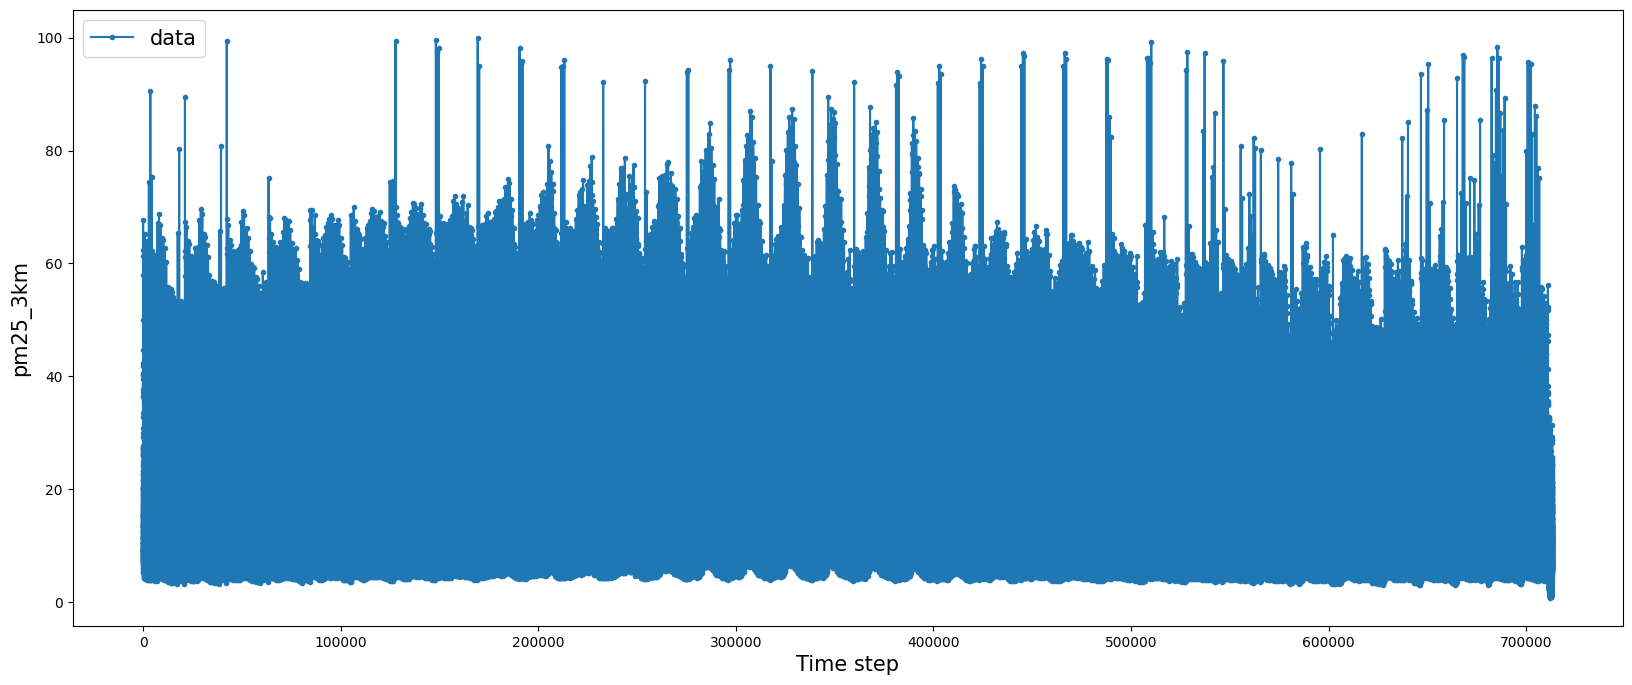

In [21]:
plot_1_data(data=y_mpair, datalabel="data", xlabel="Time step", ylabel="pm25_3km")

### Data normalization

In [22]:
mpair_features_scaler = MinMaxScaler()
X_mpair_scaled = mpair_features_scaler.fit_transform(X_mpair)
X_mpair_scaled = pd.DataFrame(X_mpair_scaled, columns=X_mpair.columns)
X_mpair_scaled

,lat,lon,pop,road_den_1km,road_len_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,wspd,aod,hpbl,pres2m,tmp,rh
0,1.0,0.000000,0.002224,0.141639,0.153096,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.477011,0.112335,0.354281,0.792823,0.377580,0.308914
1,1.0,0.000000,0.002224,0.141639,0.153096,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.318837,0.112335,0.301440,0.753260,0.295472,0.420709
2,1.0,0.000000,0.002224,0.141639,0.153096,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.254553,0.112335,0.248758,0.714287,0.373292,0.391269
3,1.0,0.000000,0.002224,0.141639,0.153096,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.345783,0.109521,0.442676,0.708313,0.411267,0.460537
4,1.0,0.000000,0.002224,0.141639,0.153096,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.311317,0.112335,0.332955,0.712440,0.371630,0.522220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713205,0.0,0.857143,0.020028,0.071699,0.000000,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.235005,0.088991,0.272944,0.957227,0.341558,0.563799
713206,0.0,0.857143,0.020028,0.071699,0.000000,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.184759,0.088991,0.248323,0.940860,0.374293,0.607092
713207,0.0,0.857143,0.020028,0.071699,0.000000,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.159747,0.040508,0.262799,0.943077,0.403927,0.632859
713208,0.0,0.857143,0.020028,0.071699,0.000000,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.231359,0.088991,0.143866,0.955652,0.340895,0.566729


In [23]:
mpair_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_mpair_scaled = mpair_label_scaler.fit_transform(y_mpair)
y_mpair_scaled = pd.DataFrame(y_mpair_scaled, columns=y_mpair.columns)
y_mpair_scaled

,pm25_3km
0,0.254398
1,0.389835
2,0.401432
3,0.398508
4,0.496127
...,...
713205,0.192223
713206,0.168370
713207,0.177639
713208,0.119317


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25_3km as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [24]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [25]:
RANGE_OF_DIMENSION = range(conf.data["reduction"]["min_number_of_features"], X_mpair_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

18 19 

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  lstms2s = LSTMSeq2SeqReduction(X_mpair_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 epochs=conf.data["reduction"]["epochs"], batch_size=conf.data["reduction"]["batch_size"],
                                 verbose=1,
                                 model_name=f"mpair_lstms2s_dim_reduction_{n}_features")
  X_mpair_scaled_lstm_s2s_encoded = lstms2s.execute()

  lstms2s.get_model_info()
  lstms2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_mpair_scaled_lstm_s2s_encoded, y_mpair_scaled,
                             conf.data["prediction"]["n_past"], conf.data["prediction"]["n_future"], conf.data["prediction"]["epochs"], conf.data["prediction"]["batch_size"],
                             model_name=f"mpair_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                             verbose=1)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)

  # Logging
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_mpair_scaled_lstm_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

LSTMSeq2SeqReduction._prepare_data(): is called
Reframing data over 713210 entries...


  0%|          | 0/713210 [00:00<?, ?it/s]

IOStream.flush timed out


In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf.data["prediction"]["n_future"]):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

In [ ]:
stophere

### Prediction + GRU-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  grus2s = GRUSeq2SeqReduction(X_mpair_scaled, test_percentage=0.2, latent_dim=n, epochs=SEQ2SEQ_EPOCHS, batch_size=SEQ2SEQ_BATCH_SIZE, verbose=0)
  X_mpair_scaled_gru_s2s_encoded = grus2s.execute()

  grus2s.get_model_info()
  grus2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_mpair_scaled_gru_s2s_encoded, y_mpair_scaled,
                             MPAIR_LSTM_N_PAST, MPAIR_LSTM_N_FUTURE, MPAIR_LSTM_EPOCHS, MPAIR_LSTM_BATCH_SIZE,
                             model_name=f"mpair_lstm_grus2s_dim_reduction_{n}_features",
                             verbose=0)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)

  # Logging
  print(f"N = {n} - MAE = {avg_mae}")
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_mpair_scaled_gru_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.1))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(MPAIR_LSTM_N_FUTURE):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  cnnlstms2s = CNNLSTMSeq2SeqReduction(X_mpair_scaled, test_percentage=0.2, latent_dim=n, epochs=SEQ2SEQ_EPOCHS, batch_size=SEQ2SEQ_BATCH_SIZE, verbose=0)
  X_mpair_scaled_cnnlstm_s2s_encoded = cnnlstms2s.execute()

  cnnlstms2s.get_model_info()
  cnnlstms2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_mpair_scaled_cnnlstm_s2s_encoded, y_mpair_scaled,
                             MPAIR_LSTM_N_PAST, MPAIR_LSTM_N_FUTURE, MPAIR_LSTM_EPOCHS, MPAIR_LSTM_BATCH_SIZE,
                             model_name=f"mpair_lstm_cnnlstm_s2s_dim_reduction_{n}_features",
                             verbose=0)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)

  # Logging
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_mpair_scaled_cnnlstm_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["CNN-LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(MPAIR_LSTM_N_FUTURE):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board